<a href="https://colab.research.google.com/github/arjunparmar/VIRTUON/blob/main/Harshit/Fashion_Synthesis_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!cp /drive/Shareddrives/Virtuon/Machine Learning Project/something.h5 something.h5

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tqdm
import h5py
import time
import scipy.io
%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img,img_to_array
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Input, Conv2DTranspose,MaxPool2D
from tensorflow.keras.layers import concatenate, Activation, MaxPooling2D, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.utils import Sequence,to_categorical


from tensorflow.keras.metrics import MeanIoU
import tensorflow.keras.backend as K

In [4]:
# tf.config.list_physical_devices('GPU')

In [5]:
dataset = h5py.File('/content/drive/Shareddrives/Virtuon/Machine Learning Project/G2.h5', 'r')

In [ ]:
list(dataset)

In [ ]:
dataset['b_']

In [ ]:
dataset['ih']

In [ ]:
dataset['ih_mean']

If U need to explore this dataset more read https://www.christopherlovell.co.uk/blog/2016/04/27/h5py-intro.html

First Modify Images by your own and the go down so that you will be clear of what I have done in dataset

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


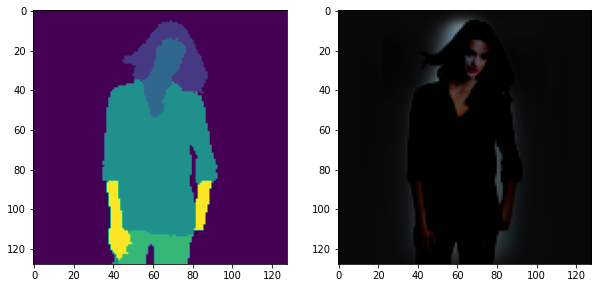

In [6]:
test_index = 1000
fig, axes = plt.subplots(1,2, figsize = [10,50])
axes[0].imshow(dataset['b_'][test_index].T.reshape(128,128))
axes[1].imshow(dataset['ih'][test_index].T.reshape(128,128,3))

In [ ]:
def preprocess(image, label):
    image = tf.transpose(image)
    label = tf.transpose(label)
    label = tf.reshape(label, [128,128])
    image = tf.image.convert_image_dtype(image, dtype = tf.uint8)
    label = tf.image.convert_image_dtype(label, dtype = tf.uint8)
    label = tf.one_hot(label, depth = 7, dtype =  tf.uint8)
#     print(label)
    return image, label

In [ ]:
train = tf.data.Dataset.from_tensor_slices((dataset['ih'][50000:60000], dataset['b_'][50000:60000]))
train = train.map(preprocess, num_parallel_calls = 4)
train = train.shuffle(10000)
train = train.batch(64).repeat()
train = train.prefetch(5)

In [ ]:
valid = tf.data.Dataset.from_tensor_slices((dataset['ih'][69500:70000], dataset['b_'][69500:70000]))
valid = valid.map(preprocess, num_parallel_calls = 4)
valid = valid.shuffle(500)
valid = valid.batch(32)

In [ ]:
def conv_2d_block(x,n_filters,k_size,batchnorm=False):
  ''' add two Conv layers with relu activation '''
  #first layer
  x = Conv2D(filters=n_filters,kernel_size=(k_size,k_size) , 
             padding='same', kernel_initializer = 'he_normal')(x)
  if batchnorm:
    x = BatchNormalization()(x)
  x = Activation('relu')(x)
  # 2nd layer
  x = Conv2D(filters=n_filters,kernel_size=(k_size,k_size) , 
              padding='same', kernel_initializer = 'he_normal')(x)
  if batchnorm:
      x = BatchNormalization()(x)
  x = Activation('relu')(x)
  
  x = Conv2D(filters=n_filters,kernel_size=(k_size,k_size) , 
              padding='same', kernel_initializer = 'he_normal')(x)
  if batchnorm:
      x = BatchNormalization()(x)
  x = Activation('relu')(x)

  return x

def get_u_net(input,n_filters=16,conv_k_size=3,pool_size=2,batchnorm=True,dropout=.2):

  c1 = conv_2d_block(input,n_filters * 1 , conv_k_size,batchnorm)
  p1 = MaxPool2D(pool_size=(pool_size,pool_size))(c1)
  p1 = Dropout(dropout)(p1)

  c2 = conv_2d_block(p1,n_filters * 2 , conv_k_size,batchnorm)
  p2 = MaxPool2D(pool_size=(pool_size,pool_size))(c2)
  p2 = Dropout(dropout)(p2)

  c3 = conv_2d_block(p2,n_filters * 4 , conv_k_size,batchnorm)
  p3 = MaxPool2D(pool_size=(pool_size,pool_size))(c3)
  p3 = Dropout(dropout)(p3)
 
  c4 = conv_2d_block(p3,n_filters * 8 , conv_k_size,batchnorm)
  p4 = MaxPool2D(pool_size=(pool_size,pool_size))(c4)
  p4 = Dropout(dropout)(p4)

  c5 = conv_2d_block(p4,n_filters * 16 , conv_k_size,batchnorm)

   #Up sampling
  u6 = Conv2DTranspose(filters=n_filters * 8 ,kernel_size=(3,3), strides=(2,2),padding='same')(c5)
  u6 = concatenate([u6,c4])
  u6 = Dropout(dropout)(u6)
  c7 = conv_2d_block(u6,n_filters * 8 , conv_k_size,batchnorm)

  u8 = Conv2DTranspose(filters=n_filters * 4 ,kernel_size=(3,3), strides=(2,2),padding='same')(c7)
  u8 = concatenate([u8,c3])
  u8 = Dropout(dropout)(u8)
  c9 = conv_2d_block(u8,n_filters * 4 , conv_k_size,batchnorm)

  u10 = Conv2DTranspose(filters=n_filters * 2,kernel_size=(3,3) , strides=(2,2),padding='same')(c9)
  u10 = concatenate([u10,c2])
  u10 = Dropout(dropout)(u10)
  c11 = conv_2d_block(u10,n_filters * 2 , conv_k_size,batchnorm)

  u12 = Conv2DTranspose(filters=n_filters * 1 ,kernel_size=(3,3), strides=(2,2),padding='same')(c11)
  u12 = concatenate([u12,c1])
  u12 = Dropout(dropout)(u12)
  c13 = conv_2d_block(u12,n_filters * 1 , conv_k_size,batchnorm)

  output = Conv2D(filters=7 , kernel_size=(1,1),activation='softmax')(c13) # output layer
  model = Model(inputs=input,outputs=output,name='classifier')
  return model 

In [ ]:
def DiceLoss(targets, inputs):    
    smooth=1e-6
    #flatten label and prediction tensors
    inputs = K.flatten(inputs)
    targets = K.flatten(targets)
    BCE = K.binary_cross_entropy(inputs,targets, reduction='mean')
    targets = tf.cast(targets, dtype = tf.float32)
    inputs = tf.cast(inputs, dtype = tf.float32)
    intersection = K.sum((targets *  inputs))
    union = K.sum(targets) + K.sum(inputs) - intersection
    dice_loss = 1 - ((intersection + smooth) /(union + smooth))
    Dice_BCE = dice_loss + BCE
    
    return Dice_BCE

In [ ]:
ALPHA = 1
BETA = 500
GAMMA = 1

def FocalTverskyLoss(targets, inputs, alpha=ALPHA, beta=BETA, gamma=GAMMA, smooth=1e-6):
    
        #flatten label and prediction tensors
        inputs = K.flatten(inputs)
        targets = K.flatten(targets)
        inputs = tf.cast(inputs, dtype = tf.float32)
        targets = tf.cast(targets, dtype = tf.float32)
        #True Positives, False Positives & False Negatives
        TP = K.sum((inputs * targets))
        FP = K.sum(((1-targets) * inputs))
        FN = K.sum((targets * (1-inputs)))
               
        Tversky = (TP + smooth) / (TP + alpha*FP + beta*FN + smooth)  
        FocalTversky = K.pow((1 - Tversky), gamma)
        
        return FocalTversky

In [ ]:
optimizer = Adam()
loss      = FocalTverskyLoss
metrics   = [MeanIoU(7), 'accuracy']

# Compile our model
# input = Input(shape=(128,128,3),name='img')
# model = get_u_net(input,n_filters=64)
# model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [ ]:
# model.summary()

In [ ]:
callback = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=1e-5, verbose=1)]

In [ ]:
model = tf.keras.models.load_model('something.h5', compile = False)
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [ ]:
results = model.fit(x=train,
          epochs=25,
           verbose=1,
           callbacks=callback,
                  use_multiprocessing=True,
                    workers=6, steps_per_epoch = 157, validation_data = valid)

Epoch 1/25
157/157 [==============================] - 225s 1s/step - loss: 0.8913 - mean_io_u_1: 0.9305 - accuracy: 0.9837 - val_loss: 0.8829 - val_mean_io_u_1: 0.8695 - val_accuracy: 0.9845
Epoch 2/25
157/157 [==============================] - 219s 1s/step - loss: 0.8888 - mean_io_u_1: 0.9403 - accuracy: 0.9840 - val_loss: 0.8808 - val_mean_io_u_1: 0.8741 - val_accuracy: 0.9852
Epoch 3/25
157/157 [==============================] - 219s 1s/step - loss: 0.8884 - mean_io_u_1: 0.9355 - accuracy: 0.9841 - val_loss: 0.8783 - val_mean_io_u_1: 0.9427 - val_accuracy: 0.9854
Epoch 4/25
157/157 [==============================] - 220s 1s/step - loss: 0.8872 - mean_io_u_1: 0.9299 - accuracy: 0.9843 - val_loss: 0.8845 - val_mean_io_u_1: 0.9691 - val_accuracy: 0.9846
Epoch 5/25
157/157 [==============================] - 219s 1s/step - loss: 0.8858 - mean_io_u_1: 0.9435 - accuracy: 0.9845 - val_loss: 0.8765 - val_mean_io_u_1: 0.9149 - val_accuracy: 0.9856
Epoch 6/25
157/157 [=========================

In [ ]:
model.save('something.h5')

In [ ]:
!cp something.h5 drive/MyDrive/Machine\ Learning\ Project/something.h5

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


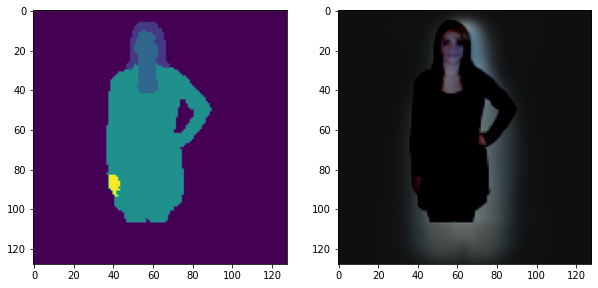

In [ ]:
test_index = 45000
fig, axes = plt.subplots(1,2, figsize = [10,50])
axes[0].imshow(dataset['b_'][test_index].T.reshape(128,128))
axes[1].imshow(dataset['ih'][test_index].T.reshape(128,128,3))

In [ ]:
dataset['ih'][test_index:test_index + 1].shape

(1, 3, 128, 128)

In [ ]:
predict_ds = tf.data.Dataset.from_tensor_slices(dataset['ih'][test_index:test_index + 1]).map(tf.transpose).batch(1)

In [ ]:
predict_ds.element_spec

TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None)

In [ ]:
result = model.predict(predict_ds)

In [ ]:
temp = tf.one_hot(dataset['b_'][test_index].T.reshape(128,128), depth = 7, dtype =  tf.uint8)
temp_1 = tf.cast(result, dtype = tf.uint8)

In [ ]:
index = 3
np.unique(temp[:,:,index] == temp_1[0,:,:,index], return_counts=True)

(array([False,  True]), array([ 2794, 13590]))

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(K.flatten(temp[:,:,index]), K.flatten(temp_1[0,:,:,index]))

array([[13590,     0],
       [ 2794,     0]])

In [ ]:
def one_hot_decoder(image):
    temp = np.zeros((128,128))
    for i in range(7):
        temp += i*image[0,:,:,i]
    return temp

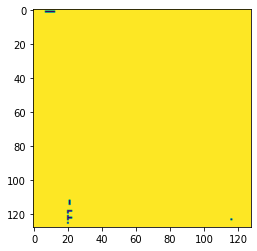

In [ ]:
plt.imshow(tf.cast(result[0,:,:,0], dtype = tf.uint8))